In [ ]:
#imports
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
load_df = pd.read_csv("/content/drive/MyDrive/dataset/load_characteristics.csv")
curtailment_df = pd.read_csv("/content/drive/MyDrive/dataset/required_curtailment.csv")

In [ ]:
load_df

,IL No,Capacity,Rate,Max_off,Min_on
0,1,320,23.8,4,2
1,2,200,25.7,4,2
2,3,80,16.9,4,2
3,4,84,16.9,4,2
4,5,100,19.2,4,2
5,6,160,23.6,4,2
6,7,100,19.2,3,1
7,8,60,16.9,3,1
8,9,200,25.7,3,1
9,10,40,16.9,4,1


In [ ]:
capacities = list(load_df["Capacity"])
curtailment_rate = list(load_df["Rate"])

In [ ]:
curtailment_df

,Hour,curtailment_A,curtailment_B
0,1,0,113.8
1,2,0,227.5
2,3,0,455.0
3,4,0,682.5
4,5,444,773.5
5,6,430,796.3
6,7,436,750.8
7,8,0,637.0
8,9,336,591.5
9,10,797,609.7


In [ ]:
priority = np.array([1, 1, 2, 2, 3, 1, 2, 3, 2, 3, 2, 2, 3, 1, 1, 3, 3, 1, 1])
print(priority.shape)

(19,)


In [ ]:
curtailment_A = np.array(curtailment_df["curtailment_A"])

In [ ]:
curtailment_B = np.array(curtailment_df["curtailment_B"])

In [ ]:
Max_off = np.array(load_df["Max_off"])
Min_on = np.array(load_df["Min_on"])

In [ ]:
len(curtailment_rate)

19

In [ ]:
'''
EXTRA CURTAILMENT CONSTRAINT
OPERATIONAL DURATION
'''

def obj_func(sol, N, T, capacity, curtailment_rate):

  sch = sol
  s1 = 0
  curtailment_count = np.zeros(N)
  UC = 0
  for t in range(T):

    hour_curtailment = 0
    curtailment_count = np.add(curtailment_count , np.array(sch[t]))
    for n in range(N):
      s1 += sch[t][n]*capacity[n]*curtailment_rate[n]*(4-priority[n])
      hour_curtailment += capacity[n]*sch[t][n]

    if hour_curtailment < curtailment_A[t]:
      UC += 1

  curtailment_count = curtailment_count.astype(int).tolist()

  curtailment_freq = [0 for _ in range(T+1)]

  for c in curtailment_count:
    for j in range(c+1):
      curtailment_freq[j] += 1

  s2 = 0
  for i in range(2, T+1):
    s2 += (2**(i-2))*curtailment_freq[i]

  s2 *= 1000

  UC *= 10000000

  #Implement PAR -----------------------

  peak_load = -float("inf")
  avg_load = 0

  for i in range(T):
    hourly_load = 0

    for j in range(N):
      if sch[i][j] == 0:
        hourly_load += capacity[n]

    if hourly_load > peak_load:
      peak_load = hourly_load

    avg_load += hourly_load

  avg_load /= T
  avg_load += 1

  PAR = 10000*(peak_load/avg_load)

  # -----------------------------------


  # ADDITIONAL CONSTRAINTS IMPLEMENTATION

  over = 0
  under = 0

  for i in range(N):
    off_hours = curtailment_count[i]
    on_hours = T-off_hours

    if off_hours > Max_off[i]:
      over += off_hours - Max_off[i]

    if on_hours < Min_on[i]:
      under += Min_on[i] - on_hours

  over *= 100000
  under *= 100000
  return -(s1 + s2 + UC + over + under)

In [ ]:
import random
import numpy as np

matrix_size = (16,19)  # Size of the 2D matrix
population_size = 20  # Number of solns
max_iterations = 200  # Max number of iterations
cr = 0.8  # Crossover rate
f = 0.5   # Differential weight
population = []


# Initialize the population
for _ in range(population_size):
    solution = np.random.choice([0, 1], size=matrix_size)
    population.append(solution)

# Main Differential Evolution loop
for iteration in range(max_iterations):
    new_population = []

    for i in range(population_size):
        a, b, c = random.sample(population, 3)

        trial_solution = population[i].copy()
        for j in range(matrix_size[0]):
            for k in range(matrix_size[1]):
                if random.random() < cr or j == random.randint(0, matrix_size[0] - 1):
                    trial_solution[j, k] = int(a[j, k] + f * (b[j, k] - c[j, k]))

        trial_fitness = obj_func(trial_solution, 19, 16, capacities, curtailment_rate)
        current_fitness = obj_func(population[i], 19, 16, capacities, curtailment_rate)

        if trial_fitness >= current_fitness:
            new_population.append(trial_solution)
        else:
            new_population.append(population[i])

    population = new_population

# Find the best solution
best_fitness = -float("inf")
best_solution = None

for x in population:
  fitness = obj_func(x, 19, 16, capacities, curtailment_rate)
  if fitness > best_fitness:
    best_solution = x
    best_fitness = fitness

print("Best solution:")
print(best_solution)
print("Best fitness:", -best_fitness)  # Convert back to positive value


Best solution:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0]
 [0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Best fitness: 189782.0


In [ ]:
best_solution

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0,

In [ ]:
G_best_x = [list(row) for row in list(best_solution)]

In [ ]:
G_best_hourly = []

for t in range(16):
  curtailed = 0
  for n in range(19):
    curtailed += G_best_x[t][n]*capacities[n]

  G_best_hourly.append(curtailed)

np.array(G_best_hourly)

array([  0,  40,  40,  80, 480, 440, 460,   0, 360, 820, 500,  80,   0,
         0, 180,   0])

In [ ]:
import matplotlib.pyplot as plt

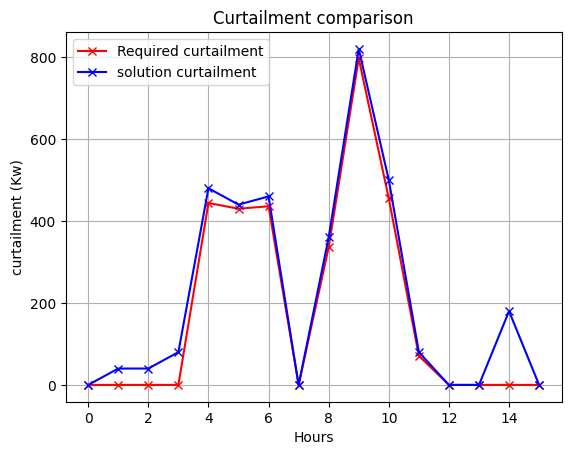

In [ ]:
plt.figure()
plt.plot(curtailment_A, marker='x', linestyle='-', color="r", label="Required curtailment")
plt.plot(G_best_hourly, marker='x', linestyle='-', color="b", label="solution curtailment")
plt.title("Curtailment comparison")
plt.xlabel("Hours")
plt.ylabel("curtailment (Kw)")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
print("----------------------IL priorities and number of times interrupted----------------------")
priority_curtailment_dict = {1:0, 2:0, 3:0}
for i in range(16):
  print(f"\nIL number {i}: priority {priority[i]}: curtailed {np.sum(G_best_x[i])}\n")
  priority_curtailment_dict[priority[i]] += np.sum(G_best_x[i])

----------------------IL priorities and number of times interrupted----------------------

IL number 0: priority 1: curtailed 0


IL number 1: priority 1: curtailed 1


IL number 2: priority 2: curtailed 1


IL number 3: priority 2: curtailed 1


IL number 4: priority 3: curtailed 4


IL number 5: priority 1: curtailed 4


IL number 6: priority 2: curtailed 3


IL number 7: priority 3: curtailed 0


IL number 8: priority 2: curtailed 2


IL number 9: priority 3: curtailed 5


IL number 10: priority 2: curtailed 2


IL number 11: priority 2: curtailed 1


IL number 12: priority 3: curtailed 0


IL number 13: priority 1: curtailed 0


IL number 14: priority 1: curtailed 1


IL number 15: priority 3: curtailed 0



In [ ]:
priority_curtailment_dict

{1: 6, 2: 10, 3: 9}

In [ ]:
off_time = []
for j in range(19):
  IL_off = 0
  for i in range(16):
    IL_off += G_best_x[i][j]

  off_time.append(IL_off)

off_time

[1, 3, 2, 0, 2, 1, 1, 0, 2, 2, 1, 0, 2, 1, 1, 2, 1, 3, 0]

In [ ]:
on_time = [16-t for t in off_time]
on_time

[15, 13, 14, 16, 14, 15, 15, 16, 14, 14, 15, 16, 14, 15, 15, 14, 15, 13, 16]

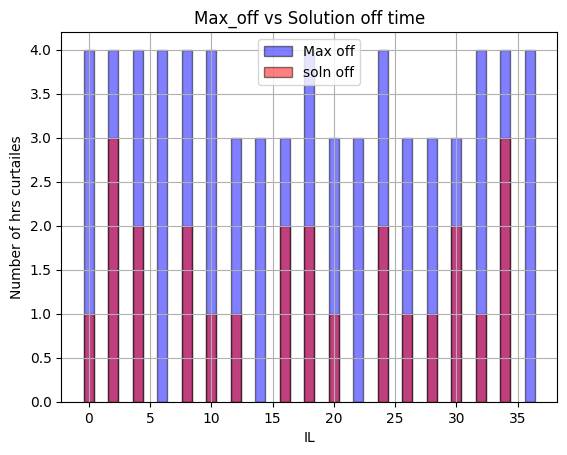

In [ ]:
bin_edges = [2*i for i in range(19)]

plt.bar(bin_edges, Max_off.tolist(), color='blue', alpha = 0.5, edgecolor='black', label='Max off')
plt.bar(bin_edges, off_time, color='red', alpha = 0.5 ,edgecolor='black', label='soln off')

plt.title('Max_off vs Solution off time')
plt.xlabel('IL')
plt.ylabel('Number of hrs curtailes')
plt.legend()
plt.grid(True)

plt.show()

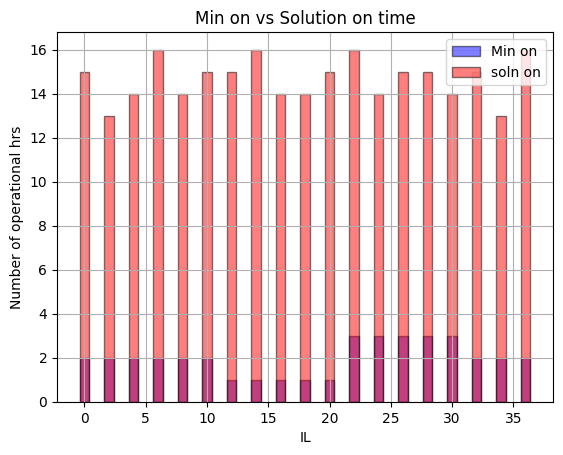

In [ ]:
bin_edges = [2*i for i in range(19)]

plt.bar(bin_edges, Min_on.tolist(), color='blue', alpha = 0.5, edgecolor='black', label='Min on')
plt.bar(bin_edges, on_time, color='red', alpha = 0.5 ,edgecolor='black', label='soln on')

plt.title('Min on vs Solution on time')
plt.xlabel('IL')
plt.ylabel('Number of operational hrs')
plt.legend()
plt.grid(True)

plt.show()